In [1]:
import utils
from train import Trainer, Tuner
from pathlib import Path
from model.bigger_leaky_unet import BiggerLeakyUnet
from IPython.display import Image
from IPython.core.display import HTML 
import numpy as np

import seaborn as sns
sns.set()

%load_ext autoreload
%autoreload 2

## optimization params

What can we optimize?

1. learning rate (the model is very sensitive to learning rate, basically nothing works except `1e-5`; `1e-6` is too slow; so we may start from `1e-5` and then reduce it gradually to `1e-6`);
2. batch size (unusually important and we forced to use very small batches of only 2 images);
3. image size (we may use 256; increasing the size up to 512 doesn't help - probably we should do some additional tests, in many situations this should help - see [fastai part2, lesson 14](https://medium.com/@hiromi_suenaga/deep-learning-2-part-2-lesson-14-e0d23c7a0add);
4. using `LeakyReLU` instead of `ReLU` and parameter `alpha` (training on toy dataset shows no difference, so we may tray );
5. model: 
    - increase number of layers (we can't see any difference on a toy dataset); 
    - add batch normalization (?);
    - kernel initializer (look like that `he_uniform` and `he_normal` (no significant difference between them) works much better than the standard keras initialization (which is `glorot_uniform`); that's not surprising - we use `ReLU` or `LeakyReLU`);
    - change optimiser (?);
6. advanced model:
    - use attention;
    - use transfer learning;

|## | parameter             | value             |
|---| ----------------      | ----------------- |
|(1)| `learning_rate`       | `1e-5`            |
|(2)| `batch size`          | `2`               |
|(3)| `input_shape`         | `256 (?)`         |
|(4)| `alpha`               | `.3 (?)`          |
|   |                       |                   |
|(5)| size of the model     | `(?)`             |
|(6)| batch normalization   | `(?)`             |
|(7)| `kernel_initializer`  | `he_uniform`      |
|(8)| `optimizer`           | `(?)`             |

Here's the list of hyperparameters from cs230 - see [here](https://cs230.stanford.edu/files/C2M3.pdf). It seems we work with the learning rate, it's decay, # of layers and mini-batch size. 

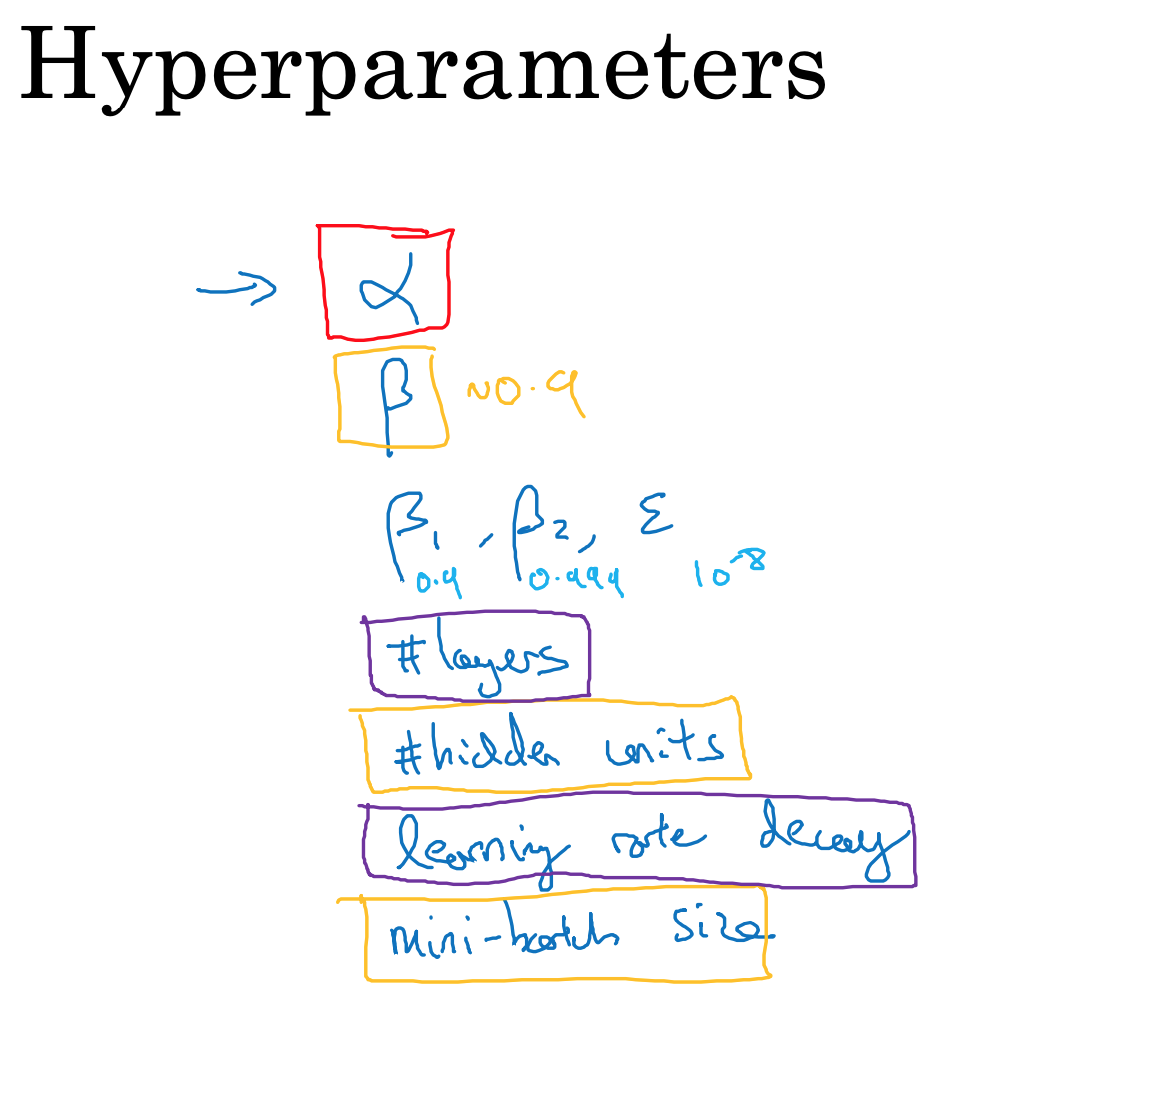

In [29]:
Image('misc/parameter_tuning_cs230.png', width=300, height=400)

## `BiggerLeakyUnet` - tuning on toy dataset

For simplicity we do all the training on a toy dataset - 10% of the original dataset. We use augmentation so we can get pretty decent results even on that dataset.

Let's do tuning of the main parameters on `BiggerLeakyUnet` model.

### (1) `learning_rate` 

Let's try to find an optimal learning rate for this model. We start search from a broad range of rates: `(1e-3, 1e-4, 1e-5, 1e-6)` and train our model for just 3 epochs. We then try to look into rates around the best one.

We may see that `1e-3` is too high, `1e-6` is too low. On this plot `1e-4` is a decent choice - but we know that's not the case on the origibal dataset. We start from `1e-5` and go down to `1e-6` but no very fast using factor `.7`. 

In [16]:
Image(url='http://cs231n.github.io/assets/nn3/learningrates.jpeg', width=200, height=200)

In [2]:
dir_path = Path('experiments/bigger_leaky_unet_toy')

In [3]:
histories_lr_toy = list(dir_path.glob('history_learning_rate*'))

In [4]:
histories_lr_toy = sorted(histories_lr_toy, key=utils.get_param_num, reverse=True)

In [5]:
histories_lr_toy

[PosixPath('experiments/bigger_leaky_unet_toy/history_learning_rate_0.001.pickle'),
 PosixPath('experiments/bigger_leaky_unet_toy/history_learning_rate_0.0001.pickle'),
 PosixPath('experiments/bigger_leaky_unet_toy/history_learning_rate_1e-05.pickle'),
 PosixPath('experiments/bigger_leaky_unet_toy/history_learning_rate_1e-06.pickle')]

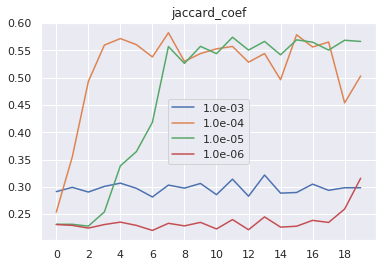

In [6]:
utils.plot_metric_paths('jaccard_coef', histories_lr_toy, param_name='learning_rate')

### (2) `batch_size`

We may see that choice of the `batch_size` matters. Probably we should stick with (unusually) small `batch_size=2`.

In [7]:
dir_path = Path('experiments/bigger_leaky_unet_toy')

In [8]:
histories_bs_toy = list(dir_path.glob('history_batch_size*'))

In [9]:
histories_bs_toy = sorted(histories_bs_toy, key=utils.get_param_num)

In [10]:
histories_bs_toy

[PosixPath('experiments/bigger_leaky_unet_toy/history_batch_size_2.pickle'),
 PosixPath('experiments/bigger_leaky_unet_toy/history_batch_size_4.pickle'),
 PosixPath('experiments/bigger_leaky_unet_toy/history_batch_size_8.pickle'),
 PosixPath('experiments/bigger_leaky_unet_toy/history_batch_size_16.pickle'),
 PosixPath('experiments/bigger_leaky_unet_toy/history_batch_size_32.pickle')]

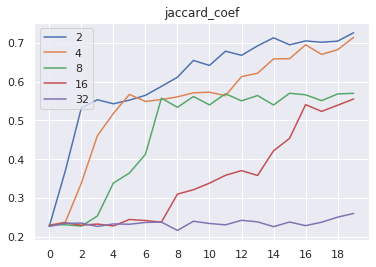

In [11]:
utils.plot_metric_paths('jaccard_coef', histories_bs_toy, param_name='batch_size')

### (3) `input_shape`

In [4]:
dir_path = Path('experiments/bigger_leaky_unet_toy')

In [13]:
histories_input_shape_toy = list(dir_path.glob('history_input_shape*'))

In [14]:
histories_input_shape_toy

[PosixPath('experiments/bigger_leaky_unet_toy/history_input_shape_512.pickle'),
 PosixPath('experiments/bigger_leaky_unet_toy/history_input_shape_256.pickle')]

In [15]:
histories_input_shape_toy = sorted(histories_input_shape_toy, key=utils.get_param_num)

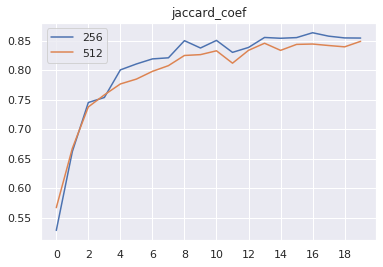

In [18]:
utils.plot_metric_paths('jaccard_coef', histories_input_shape_toy, param_name='input_shape')

### (4) `alpha` 

It looks like that `alpha=.3` (standard in `keras`) works better than low values but only for 20 epochs. For 50 epochs there's no clear winner. We may try to check it on original dataset.

In [12]:
dir_path = Path('experiments/bigger_leaky_unet_toy')

In [13]:
histories_alpha_toy = list(dir_path.glob('history_alpha*'))

In [14]:
histories_alpha_toy = np.array(sorted(histories_alpha_toy, key=utils.get_param_num))

In [15]:
histories_alpha_toy

array([PosixPath('experiments/bigger_leaky_unet_toy/history_alpha_0.pickle'),
       PosixPath('experiments/bigger_leaky_unet_toy/history_alpha_50epochs_0.001.pickle'),
       PosixPath('experiments/bigger_leaky_unet_toy/history_alpha_0.001.pickle'),
       PosixPath('experiments/bigger_leaky_unet_toy/history_alpha_0.01.pickle'),
       PosixPath('experiments/bigger_leaky_unet_toy/history_alpha_0.1.pickle'),
       PosixPath('experiments/bigger_leaky_unet_toy/history_alpha_0.2.pickle'),
       PosixPath('experiments/bigger_leaky_unet_toy/history_alpha_50epochs_0.3.pickle'),
       PosixPath('experiments/bigger_leaky_unet_toy/history_alpha_0.3.pickle')],
      dtype=object)

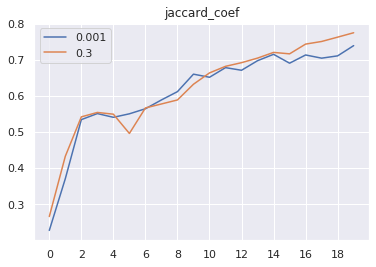

In [19]:
utils.plot_metric_paths('jaccard_coef', histories_alpha_toy[[2, 7]], param_name='alpha')

In [20]:
histories_alpha_toy_50epochs = list(dir_path.glob('history_alpha_50*'))

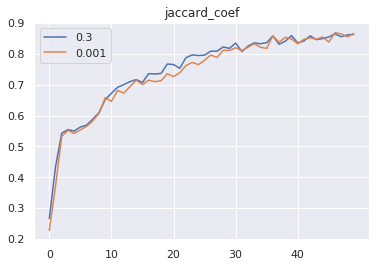

In [22]:
utils.plot_metric_paths('jaccard_coef', histories_alpha_toy_50epochs, x_axis_step=10, param_name='alpha')

### (5) size of the model

It seems the big model is slightly better on train data and the same on validation data. So we may try to train both models on our main dataset. Maybe the first model will better generelize on the test set.

In [2]:
dir_path = Path('experiments/model_size_toy')

In [3]:
histories_model_size_toy = list(dir_path.glob('history_model_size*'))

In [4]:
histories_model_size_toy

[PosixPath('experiments/model_size_toy/history_model_size_big.pickle'),
 PosixPath('experiments/model_size_toy/history_model_size_regular.pickle')]

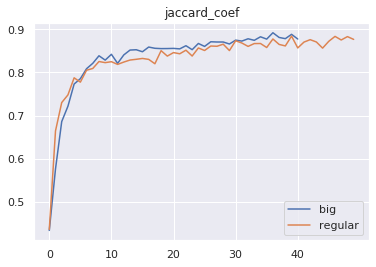

In [20]:
utils.plot_metric_paths('jaccard_coef', histories_model_size_toy, 
                        x_axis_step=10, param_name='model_size')

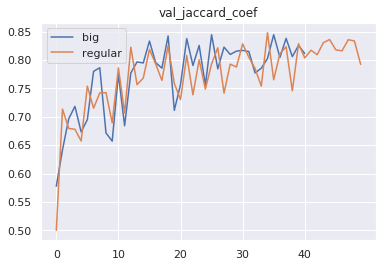

In [21]:
utils.plot_metric_paths('val_jaccard_coef', histories_model_size_toy, 
                        x_axis_step=10, param_name='model_size')

### (6) `batch_normalization`

#### 20 epochs

It looks like we need to change some parameters for the net with BN to train properly. But even with correct learning net without BN is better on 20 epochs. It can be the case that we need more than 20 epochs - net with BN can be trained slower.

In [2]:
dir_path = Path('experiments/batch_norm_toy')

In [3]:
histories_batch_norm_toy = list(dir_path.glob('history_normalization*'))

In [6]:
histories_batch_norm_toy

[PosixPath('experiments/batch_norm_toy/history_normalization_no-batch-norm.pickle'),
 PosixPath('experiments/batch_norm_toy/history_normalization_batch-norm.pickle')]

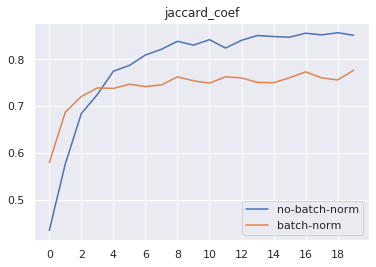

In [13]:
utils.plot_metric_paths('jaccard_coef', histories_batch_norm_toy, 
                        x_axis_step=2, param_name='model_size')

#### 50 epochs

In [19]:
histories_batch_norm_toy_50 = list(dir_path.glob('history_normalization_50e*'))

In [20]:
histories_batch_norm_toy_50

[PosixPath('experiments/batch_norm_toy/history_normalization_50e_no-batch-norm.pickle'),
 PosixPath('experiments/batch_norm_toy/history_normalization_50e_batch-norm.pickle')]

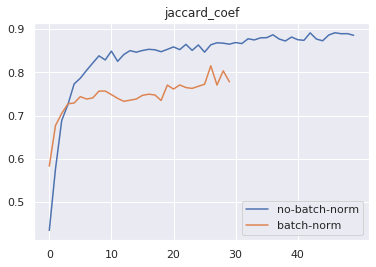

In [21]:
utils.plot_metric_paths('jaccard_coef', histories_batch_norm_toy_50, 
                        x_axis_step=10, param_name='model_size')

#### difference between train and validation metrics

Let's look at how `batch_norm` influences the difference between train and validation metrics. Again, it seems we need more than 20 epochs to understand this better. 

#### 20 epochs

In [9]:
metrics = ['jaccard_coef', 'val_jaccard_coef']

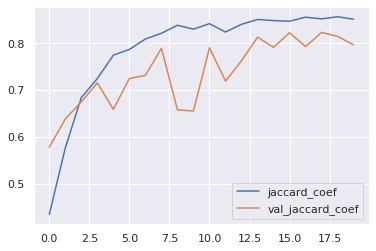

In [10]:
utils.plot_metrics_from_file(metrics, histories_batch_norm_toy[0])

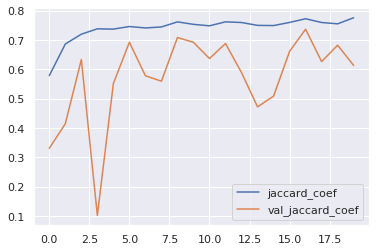

In [12]:
utils.plot_metrics_from_file(metrics, histories_batch_norm_toy[1])

#### 50 epochs

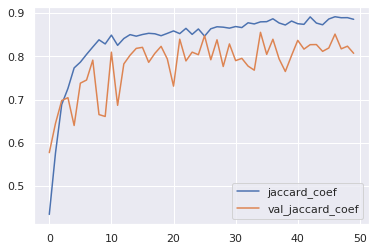

In [18]:
# no batch norm
utils.plot_metrics_from_file(metrics, histories_batch_norm_toy_50[0])

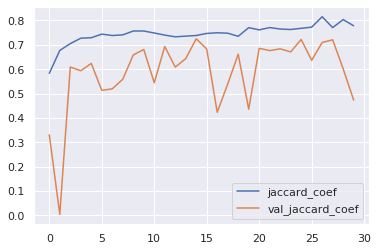

In [22]:
utils.plot_metrics_from_file(metrics, histories_batch_norm_toy_50[1])

#### tuning of `learning_rate` for `batch_norm` net

Let's try to tune learning rate for the model with batch normalization.

In [15]:
dir_path

PosixPath('experiments/batch_norm_toy')

In [44]:
histories_lr_toy = list(dir_path.glob('history_learning_rate*'))

In [45]:
histories_lr_toy = sorted(histories_lr_toy, key=utils.get_param_num, reverse=True)

In [46]:
histories_lr_toy

[PosixPath('experiments/batch_norm_toy/history_learning_rate_0.1.pickle'),
 PosixPath('experiments/batch_norm_toy/history_learning_rate_0.01.pickle'),
 PosixPath('experiments/batch_norm_toy/history_learning_rate_0.001.pickle'),
 PosixPath('experiments/batch_norm_toy/history_learning_rate_0.0001.pickle'),
 PosixPath('experiments/batch_norm_toy/history_learning_rate_1e-05.pickle'),
 PosixPath('experiments/batch_norm_toy/history_learning_rate_1e-06.pickle')]

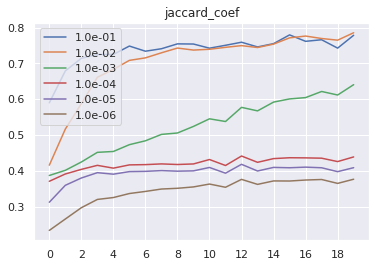

In [47]:
utils.plot_metric_paths('jaccard_coef', histories_lr_toy, param_name='learning_rate')

### (7) `kernel_initializer`

By default, `keras` uses Glorot initialization with a uniform distribution that is not suitable for `ReLU` activations. So we have to try He initialization (both uniform and normal). 

We may see that He initialization clearly outperforms Glorot initialization. But difference between different He initializations is not significant.

In [25]:
dir_path = Path('experiments/bigger_leaky_unet_toy')

In [26]:
histories_kernel_initializer_toy = list(dir_path.glob('history_kernel_initializer*'))

In [27]:
histories_kernel_initializer_toy

[PosixPath('experiments/bigger_leaky_unet_toy/history_kernel_initializer_he_normal.pickle'),
 PosixPath('experiments/bigger_leaky_unet_toy/history_kernel_initializer_glorot_uniform.pickle'),
 PosixPath('experiments/bigger_leaky_unet_toy/history_kernel_initializer_he_uniform.pickle')]

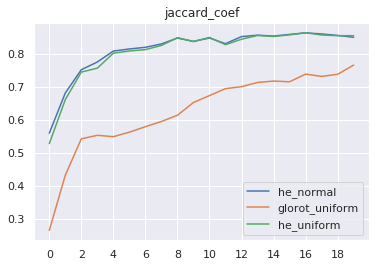

In [29]:
utils.plot_metric_paths('jaccard_coef', histories_kernel_initializer_toy, param_name='kernel_initializer')

### (8) `optimizer`

Let's now try different optimizer - `SGD` and tune learning rate for it. It looks like we may stick with the default value - `.01`. That's a good option - with `Adam` we're forced to use unusually low rates.

In [16]:
dir_path = Path('experiments/bigger_leaky_unet_sgd_toy')

In [17]:
histories_sgd_lr_toy = list(dir_path.glob('history_learning_rate*'))

In [18]:
histories_sgd_lr_toy = sorted(histories_sgd_lr_toy, key=utils.get_param_num, reverse=True)

In [19]:
histories_sgd_lr_toy

[PosixPath('experiments/bigger_leaky_unet_sgd_toy/history_learning_rate_0.1.pickle'),
 PosixPath('experiments/bigger_leaky_unet_sgd_toy/history_learning_rate_0.01.pickle'),
 PosixPath('experiments/bigger_leaky_unet_sgd_toy/history_learning_rate_0.001.pickle'),
 PosixPath('experiments/bigger_leaky_unet_sgd_toy/history_learning_rate_0.0001.pickle')]

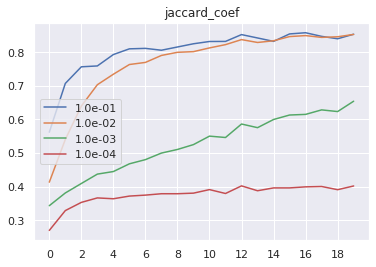

In [20]:
utils.plot_metric_paths('jaccard_coef', histories_sgd_lr_toy, param_name='learning_rate')